(0.2, 2.0)

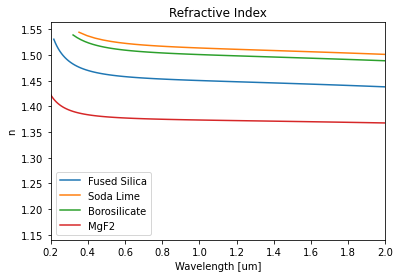

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from PIL import Image
from scipy.signal import savgol_filter
    
n_air = 1;
all_glass = []
#importing_data
n_fs = pd.read_csv('../input/glass-data/Fused_silica.csv',header=1)
n_fs = n_fs.values;
k_fs = np.zeros([len(n_fs),1])
n_fs = np.hstack([n_fs,k_fs])
all_glass.append(n_fs)

n_sl = pd.read_csv('../input/glass-data/Soda_lime.csv',header=1)
n_sl = n_sl.values;
k_sl = np.zeros([len(n_sl),1])
n_sl = np.hstack([n_sl,k_sl])
all_glass.append(n_sl)

n_bs = pd.read_csv('../input/glass-data/Borosilicate.txt',header=1,delimiter="\t")
n_bs = n_bs.values;
k_bs = np.zeros([len(n_bs),1])
n_bs = np.hstack([n_bs,k_bs])
all_glass.append(n_bs)

n_mgf2 = pd.read_csv('../input/glass-data/MgF2.csv',header=0)
n_mgf2 = n_mgf2.values;
k_mgf2 = np.zeros([len(n_mgf2),1])
n_mgf2 = np.hstack([n_mgf2,k_mgf2])
all_glass.append(n_mgf2)

n_btio2 = pd.read_csv('../input/glass-data/btio2.csv',header=None)
n_btio2 = n_btio2.values;
n_btio2[:,0] = n_btio2[:,0]*1e-3
#n_btio2 = n_btio2-1e-3*1j
all_glass.append(n_btio2)

n_fs_d2 = pd.read_csv('../input/glass-data/Fused_silica.csv',header=1)
n_fs_d2 = n_fs_d2.values
n_fs_d2[:,1] = (n_fs_d2[:,1]+1)/2
k_fs_d2 = np.zeros([len(n_fs_d2),1])
n_fs_d2 = np.hstack([n_fs_d2,k_fs_d2])
all_glass.append(n_fs_d2)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

plt.plot(n_fs[:,0],n_fs[:,1],n_sl[:,0],n_sl[:,1],n_bs[:,0],n_bs[:,1],n_mgf2[:,0],n_mgf2[:,1])
plt.legend(['Fused Silica','Soda Lime','Borosilicate','MgF2'])
plt.title('Refractive Index')
plt.xlabel('Wavelength [um]')
plt.ylabel('n')
plt.xlim([0.2,2])

In [2]:
def layer_coh_p(n1,n2,n3,d,k,theta):
    theta1 = np.conj(np.arcsin(n_air*np.sin(theta)/n1))
    theta2 = np.conj(np.arcsin(n_air*np.sin(theta)/n2))
    theta3 = np.conj(np.arcsin(n_air*np.sin(theta)/n3))
    phi1 = k*n2*d*np.cos(theta2)
    r_p = (n2*np.cos(theta1)-n1*np.cos(theta2))/(n2*np.cos(theta1)+n1*np.cos(theta2))
    r_p2 = (n1*np.cos(theta2)-n2*np.cos(theta1))/(n1*np.cos(theta2)+n2*np.cos(theta1))
    t_p = (2*n2*np.cos(theta2))/(n3*np.cos(theta2)+n2*np.cos(theta3))
    t_p2 = (2*n3*np.cos(theta3))/(n2*np.cos(theta3)+n3*np.cos(theta2))
    M1 = np.array([[1,r_p],[-r_p2,t_p*t_p2-r_p*r_p2]])
    P = np.array([[np.exp(1j*phi1),0],[0,np.exp(-1j*phi1)]])
    M2 = np.array([[1/t_p,0],[0,1/t_p]])
    return M1,P,M2

def layer_coh_s(n1,n2,n3,d,k,theta):
    theta1 = np.conj(np.arcsin(n_air*np.sin(theta)/n1))
    theta2 = np.conj(np.arcsin(n_air*np.sin(theta)/n2))
    theta3 = np.conj(np.arcsin(n_air*np.sin(theta)/n3))
    #print(theta1,theta2,theta3)
    phi1 = k*n2*d*np.cos(theta2)
    r_s = (n1*np.cos(theta1)-n2*np.cos(theta2))/(n1*np.cos(theta1)+n2*np.cos(theta2))
    r_s2 = (n2*np.cos(theta2)-n1*np.cos(theta1))/(n2*np.cos(theta2)+n1*np.cos(theta1))
    t_s = (2*n2*np.cos(theta2))/(n2*np.cos(theta2)+n3*np.cos(theta3))
    t_s2 = (2*n3*np.cos(theta3))/(n3*np.cos(theta3)+n2*np.cos(theta2))
    M1 = np.array([[1,r_s],[-r_s2,t_s*t_s2-r_s*r_s2]])
    P = np.array([[np.exp(1j*phi1),0],[0,np.exp(-1j*phi1)]])
    M2 = np.array([[1/t_s,0],[0,1/t_s]])
    return M1,P,M2

def t0_p(n1,n2,theta):
    theta1 = np.conj(np.arcsin(n_air*np.sin(theta)/n1))
    return (2*n1*np.cos(theta1))/(n2*np.cos(theta1)+n1*np.sqrt(1-(n1*np.sin(theta1)/n2)**2))

def rf_p(n1,n2,theta):
    theta1 = np.conj(np.arcsin(n_air*np.sin(theta)/n1))
    return (n2*np.cos(theta1)-n1*np.sqrt(1-(n1*np.sin(theta1)/n2)**2))/(n1*np.sqrt(1-(n1*np.sin(theta1)/n2)**2)+n2*np.cos(theta1))

def t0_s(n1,n2,theta):
    theta1 = np.conj(np.arcsin(n_air*np.sin(theta)/n1))
    return (2*n1*np.cos(theta1))/(n1*np.cos(theta1)+n2*np.sqrt(1-(n1*np.sin(theta1)/n2)**2))
def rf_s(n1,n2,theta):
    theta1 = np.conj(np.arcsin(n_air*np.sin(theta)/n1))
    return (n1*np.cos(theta1)-n2*np.sqrt(1-(n1*np.sin(theta1)/n2)**2))/(n1*np.cos(theta1)+n2*np.sqrt(1-(n1*np.sin(theta1)/n2)**2))

In [3]:

def all_mat_p(index,thickness,coherence,lam,theta):
    M = [];
    k = 2*np.pi/lam
    t1 = t0_p(index[0],index[1],theta)
    M.append(np.array([[1/t1,0],[0,1/t1]]))
    for l in range(len(thickness)):
        M1,P,M2 = layer_coh_p(index[l],index[l+1],index[l+2],thickness[l],k,theta)
        M.append(M1);M.append(P);M.append(M2);
    rf_1 = rf_p(index[-2],index[-1],theta)
    M.append(np.array([[1,rf_1],[rf_1,1]]))
    return M


def all_mat_s(index,thickness,coherence,lam,theta):
    M = [];
    k = 2*np.pi/lam
    t1 = t0_p(index[0],index[1],theta)
    M.append(np.array([[1/t1,0],[0,1/t1]]))
    for l in range(len(thickness)):
        M1,P,M2 = layer_coh_s(index[l],index[l+1],index[l+2],thickness[l],k,theta)
        M.append(M1);M.append(P);M.append(M2);
    rf_1 = rf_s(index[-2],index[-1],theta)
    M.append(np.array([[1,rf_1],[rf_1,1]]))
    return M

def reduce_mat(M,coherence):
    l = 0;
    inc_index = []
    for l in range(len(coherence)-1):
        if coherence[l] == 'incoh':
            inc_index.append(l*3-2)
            inc_index.append(l*3-1)
    inc_index.append((len(coherence)-2)*3+1)
    inc = 0;
    Ms = []
    for l in inc_index:
        inter_mat = np.array([[1,0],[0,1]])
        for ll in range(inc,l+1):
            inter_mat = np.matmul(inter_mat,M[ll])
        Ms.append(np.abs(inter_mat)**2)
        inc = l+1
    Mt = np.array([[1,0],[0,1]])
    for l in range(len(Ms)):
        Mt = np.matmul(Mt,Ms[l])
    return Mt[1,0]/Mt[0,0], 1/Mt[0,0]
            

In [4]:
def eh_profile(ang,r2,r3,r4,n1,n2,plot=True):
    ang = ang*np.pi/180
    sl = -1/np.tan(ang)
    b = (1-r3)/(np.tan(ang))
    x1 = np.arange(0,1,0.01)
    y1 = np.zeros(len(x1))
    for xx in x1:
        if np.abs(xx)<r2:
            y1[np.where(x1 == xx)] = sl*r2+b
        elif np.abs(xx)>(1-r4):
            y1[np.where(x1 == xx)] = 0
        else:
            y1[np.where(x1 == xx)] = sl*xx+b
    
    if plot:
        x1 = np.arange(0,1,0.01);x3 = np.arange(2,3,0.01);x5 = np.arange(4,5,0.01)
        x2 = np.arange(-1,0,0.01);x4 = np.arange(1,2,0.01);x6 = np.arange(3,4,0.01)    
        y2 = y1[-1::-1]
        y = np.concatenate([y2,y1,y2,y1,y2,y1]);x = np.concatenate([x2,x1,x4,x3,x6,x5])
        plt.plot(x,y);
        plt.gca().set_aspect('equal')
        
    #area calculation
    z1 = sl*r2+b
    zz = np.arange(z1,0,-0.01);
    #xx = np.linspace(0,1,len(zz))
    area = ((zz-b)*2/sl)**2
    index = n2*area/4+n1*(4-area)/4
    index[0] = n1
    return index

def index_step(index,thickness,nb_layers):
    d = thickness/nb_layers
    xx = np.linspace(0,thickness,len(index))
    #xx2 = np.linspace(0+d/2,thickness-d/2,nb_layers)
    xx2 = np.linspace(0,thickness,nb_layers)
    index_profile = np.interp(xx2,xx,index)
    return index_profile

def eh_layers(lam,factor,thickness,n1,n2):
    d_profile = []
    index_profile = []
    mfp = lam/factor
    nb_layers = int(np.floor(thickness/mfp))
    if nb_layers >0:
        d = thickness/nb_layers
        index_func = eh_profile(ang,r2,r3,r4,n1,n2,plot=False)
        index_layers = index_step(index_func,thickness,nb_layers)
        d_profile = np.append(d_profile,np.linspace(d,d,nb_layers))
        index_profile = np.append(index_profile,index_layers)
    return d_profile,index_profile

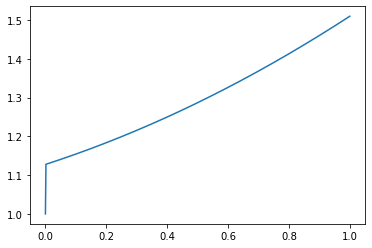

In [5]:
ang = 5; r2=0.5;r3=0.0;r4=r3;n1 = 1;n2 = 1.51
eh_prof = eh_profile(ang,r2,r3,r4,n1,n2,plot=False)
plt.plot(np.linspace(0,1,len(eh_prof)),eh_prof)

In [6]:
class tmm_model():
    def __init__(self):
        self.index = [1,'n_fs']
        self.thickness = []
        self.coherence = ['coh','coh']
        self.n_type = []
        self.eff_M = []
        self.refl = np.array([])
        self.trans = np.array([])
        self.lam_t = np.linspace(350*1e-9,1100*1e-9,226)
        self.theta_t = np.array(np.linspace(0,80,1))*np.pi/180
        self.factor = 17
        self.window = 3
        
    def add_layer(self,**kwargs):
        self.index.insert(len(self.index)-1,kwargs.get('n','n_fs'));
        self.thickness.insert(len(self.thickness),kwargs.get('d',1e-6));
        self.coherence.insert(len(self.coherence)-1,kwargs.get('c','incoh'))   
    
    def summary(self):
        print('n = ' + str(self.index[0]))
        print('----------------------')
        for ll in range(len(self.thickness)):
            print('n = ' + str(self.index[ll+1]) + "\t" + 'd = ' + str(self.thickness[ll]))
            print('----------------------')
        print('n = ' + str(self.index[-1]))
        
    def plot_refl(self,avg=False,order=1):
        if self.refl.ndim>1:
            for l in range(len(self.refl)):
                if avg:
                    refl2 = savgol_filter(self.refl[l], self.window, order)
                else:
                    refl2 = self.refl[l]
                plt.plot(self.lam_t*1e9,refl2)
                plt.title('Transmittance')
                plt.xlabel('Wavelength [nm]')
                plt.ylabel('T')
        else:
            #z = np.polyfit(self.lam_t, self.refl,order)
            #y_hat = np.poly1d(z)(self.lam_t)
            #plt.plot(self.lam_t*1e9,y_hat)
            if avg:
                refl2 = savgol_filter(self.refl, self.window, order)
            else:
                refl2 = self.refl
            refl2 = savgol_filter(self.refl, self.window, order)
            plt.plot(self.lam_t*1e9,refl2)
            plt.title('Reflectance')
            plt.xlabel('Wavelength [nm]')
            plt.ylabel('R')
        
    def plot_trans(self,avg=False,order=1):
        if self.trans.ndim>1:
            for l in range(len(self.trans[l])):
                if avg:
                    trans2 = savgol_filter(self.trans[l], self.window, order)
                else:
                    trans2 = self.trans[l]
                plt.plot(self.lam_t*1e9,trans2)
                plt.title('Reflectance')
                plt.xlabel('Wavelength [nm]')
                plt.ylabel('R')
        else:
            if avg:
                trans2 = savgol_filter(self.trans, self.window, order)
            else:
                trans2 = self.trans
            plt.plot(self.lam_t*1e9,trans2)
            plt.title('Transmittance')
            plt.xlabel('Wavelength [nm]')
            plt.ylabel('T')

    def calculate(self):
        self.refl = np.array([])
        self.trans = np.array([])
        pos = [];
        pos2 = [];
        npostype = [];
        layer_index = self.index[:]
        self.window = 3
        
        for l in range(len(layer_index)):
            if type(layer_index[l]) == str:
                if layer_index[l] == 'n_fs':
                    pos.append(l)
                    npostype.append(0)
                elif layer_index[l] == 'n_sl':
                    pos.append(l)
                    npostype.append(1)
                elif layer_index[l] == 'n_bs':
                    pos.append(l)
                    npostype.append(2)
                elif layer_index[l] == 'n_mgf2':
                    pos.append(l)
                    npostype.append(3)
                elif layer_index[l] == 'n_btio2':
                    pos.append(l)
                    npostype.append(4)
                elif layer_index[l] == 'n_fs_d2':
                    pos.append(l)
                    npostype.append(5)
                elif layer_index[l] == 'eh':
                    pos2.append(l)
                    self.window = int(len(self.lam_t)/4)*2+1
                else:
                    print('One of the material not recognize')
                    pos.append(l)
                    npostype.append(1)
        
        for theta in self.theta_t:
            r_lam = np.array([])
            t_lam = np.array([])
            for lam in self.lam_t:
                layer_index = self.index[:]
                layer_thickness = self.thickness[:]
                layer_coherence = self.coherence[:]
                for ll in range(len(pos)):
                    layer_index[pos[ll]] = np.interp(lam, all_glass[npostype[ll]][:,0]*1e-6, all_glass[npostype[ll]][:,1])+1j*np.interp(lam, all_glass[npostype[ll]][:,0]*1e-6, all_glass[npostype[ll]][:,2])
                for ll in pos2:
                    add_up = len(layer_thickness)-len(self.thickness)
                    d_eh,ind_eh = eh_layers(lam,self.factor,layer_thickness[ll+add_up-1],layer_index[ll+add_up-1],layer_index[ll+add_up+1])
                    del layer_thickness[ll+add_up-1];
                    del layer_index[ll+add_up];
                    del layer_coherence[ll+add_up];
                    for lll in range(len(d_eh)):
                        layer_thickness.insert(ll-1+lll+add_up,d_eh[lll])
                        layer_index.insert(ll+lll+add_up,ind_eh[lll])
                        layer_coherence.insert(ll+lll+add_up,'coh')
                all_matp = all_mat_p(layer_index,layer_thickness,layer_coherence,lam,theta)
                r_p,t_p = reduce_mat(all_matp,layer_coherence)
                all_mats = all_mat_s(layer_index,layer_thickness,layer_coherence,lam,theta)
                r_s,t_s = reduce_mat(all_mats,layer_coherence)
                # for the next 2 lines, *layer_index not verified but pretty sure
                r_lam = np.append(r_lam,((r_p+r_s)/2)*np.real(layer_index[0]))
                t_lam = np.append(t_lam,((t_p+t_s)/2)*np.real(layer_index[-1]))
            if theta == self.theta_t[0]:
                self.refl = r_lam
                self.trans = t_lam
            else:
                self.refl = np.vstack([self.refl,r_lam])
                self.trans = np.vstack([self.trans,t_lam])


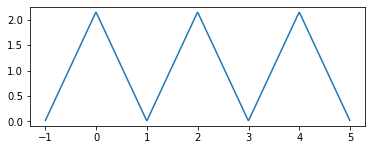

In [7]:
ang = 25; r2=0.0;r3=0.0;r4=r3;

a=eh_profile(ang,r2,r3,r4,n1,n2,plot=True)

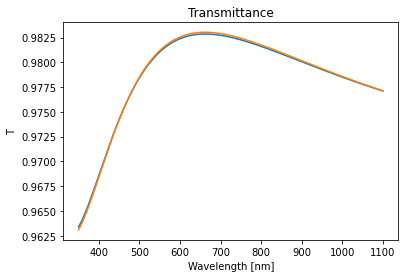

In [8]:
model1 = tmm_model()
model1.add_layer(n='n_mgf2',d=120e-9,c='coh')
model1.add_layer(n='n_fs',d=100e-3,c='incoh')
model1.calculate()
model1.plot_trans()
plt.plot(model1.lam_t*1e9,1-model1.refl)

import pandas as pd
PHD_STIPENDS = pd.read_csv('/kaggle/input/phd-stipends/csv') # load from notebook input
PHD_STIPENDS.to_csv('/kaggle/working/phd_stipends.csv',index=False)

In [10]:
np.savetxt('data.csv', 1-model1.refl, delimiter=',')